In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to load the PPI network from a file and construct a directed graph
def load_ppi_network(file_path):
    """
    Reads the PPI network file and creates a directed graph using NetworkX.
    
    Args:
        file_path (str): Path to the interactome file.
    
    Returns:
        networkx.DiGraph: A directed graph representing the PPI network.
    """
    G = nx.DiGraph()  # Create a directed graph
    with open(file_path, 'r') as f:
        for line in f:
            # Skip headers or malformed lines by checking if the first element is not a protein ID
            if line.startswith("tail") or line.startswith("#") or "edge_weight" in line:
                continue  # Skip the header line

            try:
                # Split each line into four parts: tail, head, weight, method
                tail, head, weight, method = line.strip().split("\t")
                G.add_edge(tail, head, weight=float(weight), method=method)  # Add edge with weight and method
            except ValueError as e:
                print(f"Skipping line due to error: {line.strip()} - {e}")
    
    return G

# Example usage: Load the interactome file
ppi_network = load_ppi_network("PathLinker_2018_human-ppi-weighted-cap0_75.txt")


## Log Transformation

In [24]:
import math

def find_acyclic_shortest_paths(graph, source, target):
    """
    Finds the most confident (highest probability) acyclic paths between two proteins in a directed graph.

    Args:
        graph (networkx.DiGraph): The PPI network.
        source (str): UniProt ID of the source protein.
        target (str): UniProt ID of the target protein.

    Returns:
        list of tuples: Each tuple contains (path, total_path_score, interaction_weights).
    """
    try:
        # Convert probabilities to negative log values for path minimization
        for u, v, d in graph.edges(data=True):
            if d['weight'] == 0:
                d['cost'] = -math.log(d['weight']+1e-10)
            else:
                d['cost'] = -math.log(d['weight'])  # Transform confidence to cost

        # Find all shortest paths based on weight using Dijkstra's algorithm
        paths = list(nx.all_shortest_paths(graph, source=source, target=target, weight='cost', method='dijkstra'))
        #paths = list(nx.all_shortest_paths(graph, source=source, target=target, weight='weight', method='dijkstra'))
        path_details = []
        
        for path in paths:
            # Calculate the total path score (sum of edge weights)
            path_cost = math.prod(graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1))
            # Get individual interaction weights along the path
            interaction_cost = [graph[path[i]][path[i+1]]['weight'] for i in range(len(path) - 1)]
            path_details.append((path, path_cost, interaction_cost))        
        return path_details

    except nx.NetworkXNoPath:
        # Handle the case when no path exists between the given nodes
        print(f"No path found between {source} and {target}")
        return []




In [25]:
# Function to write the path details to a text file
def write_paths_to_file(paths, output_file):
    """
    Writes the computed shortest paths and their details to a text file.

    Args:
        paths (list): List of paths with scores and Cost.
        output_file (str): Name of the output text file.
    """
    with open(output_file, 'w') as f:
        for path, total_score, Cost in paths:
            f.write(f"Path: {' -> '.join(path)}\n")  # Write the path in readable format
            f.write(f"Total Score: {total_score}\n")  # Write the total path score
            f.write(f"Confidence: {Cost}\n")  # Write the individual Cost of interactions
            f.write("\n")  # Add spacing between paths


In [26]:
available_proteins = set(ppi_network.nodes)
print("Available proteins in network (first 10):", list(available_proteins)[:10])

Available proteins in network (first 10): ['O14929', 'P15382', 'A6PVS8', 'Q8N3A8', 'Q96PI1', 'Q9Y483', 'P57771', 'O43583', 'O15105', 'P51798']


In [27]:
# Example usage: Find shortest paths and save them to a file
source_protein = "Q9HBV2"
target_protein = "Q9Y4W2"

if source_protein not in ppi_network.nodes:
    print(f"Error: Source protein {source_protein} not found in the network.")
if target_protein not in ppi_network.nodes:
    print(f"Error: Target protein {target_protein} not found in the network.")

shortest_paths = find_acyclic_shortest_paths(ppi_network, source_protein, target_protein)

write_paths_to_file(shortest_paths, "log_shortest_paths.txt")


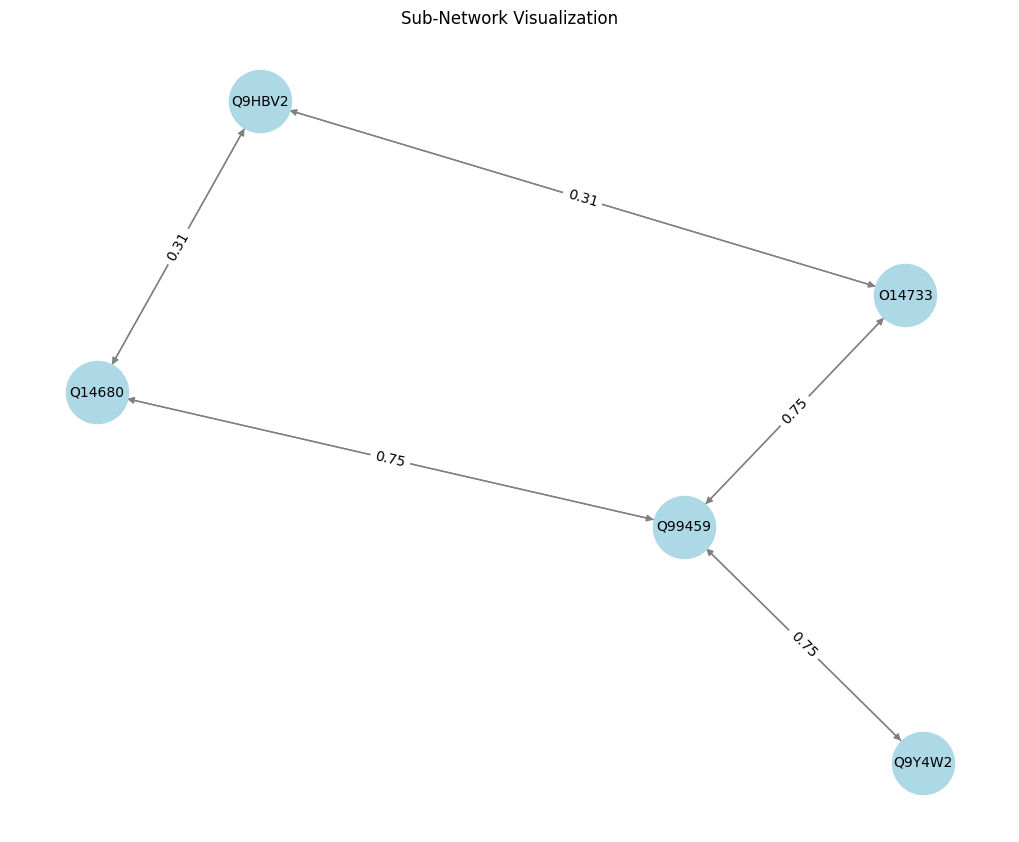

In [28]:
# Function to visualize the sub-network formed by the shortest paths
def visualize_subnetwork(graph, paths, output_image):
    """
    Extracts and visualizes the sub-network formed by the shortest paths.

    Args:
        graph (networkx.DiGraph): The PPI network.
        paths (list): List of shortest paths.
        output_image (str): File name to save the visualization.
    """
    subgraph_nodes = set()  # Set to collect unique nodes from paths
    for path, _, _ in paths:
        subgraph_nodes.update(path)  # Add all nodes from each path
    
    subgraph = graph.subgraph(subgraph_nodes)  # Create a subgraph with selected nodes
    
    # Define layout for visualization
    pos = nx.spring_layout(subgraph)  
    # Create edge labels with interaction weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
    
    # Create the visualization
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', 
            node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    
    plt.title("Sub-Network Visualization")
    plt.savefig(output_image)  # Save the plot as an image
    plt.show()


# Example usage: Visualize and save the sub-network formed by shortest paths
visualize_subnetwork(ppi_network, shortest_paths, "subnetwork.png")


Path_1
(['Q9HBV2', 'O14733', 'Q99459', 'Q9Y4W2'], 0.1750123125, [0.311133, 0.75, 0.75])


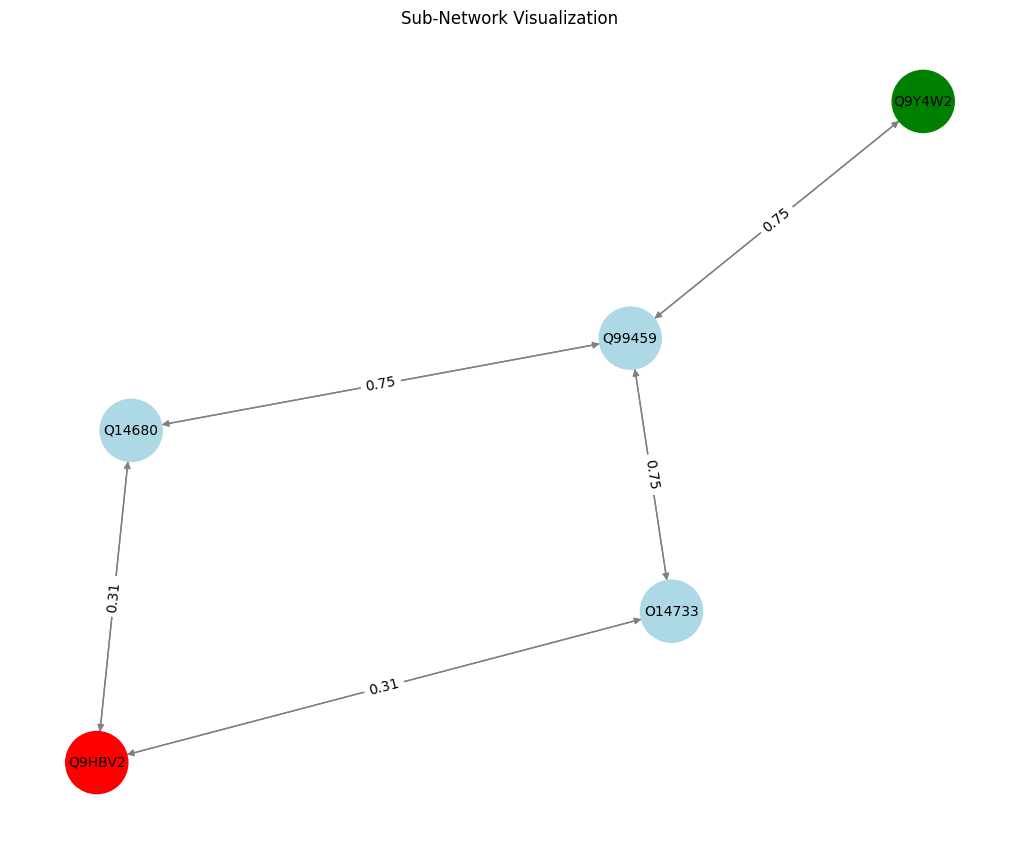

In [29]:
# Function to visualize the sub-network formed by the shortest paths
def visualize_subnetwork(graph, paths, output_image, source, target):
    """
    Extracts and visualizes the sub-network formed by the shortest paths.

    Args:
        graph (networkx.DiGraph): The PPI network.
        paths (list): List of shortest paths.
        output_image (str): File name to save the visualization.
        source (str): Source protein ID.
        target (str): Target protein ID.
    """
    subgraph_nodes = set()  # Set to collect unique nodes from paths
    for path, _, _ in paths:
        subgraph_nodes.update(path)  # Add all nodes from each path
    
    subgraph = graph.subgraph(subgraph_nodes)  # Create a subgraph with selected nodes
    
    # Define layout for visualization
    pos = nx.spring_layout(subgraph)  
    # Create edge labels with interaction weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
    
    # Color nodes differently for source and target
    node_colors = ['red' if node == source else 'green' if node == target else 'lightblue' for node in subgraph.nodes]
    
    # Create the visualization
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color='gray', 
            node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    
    plt.title("Sub-Network Visualization")
    plt.savefig(output_image)  # Save the plot as an image
    plt.show()

# Example usage: Visualize and save the sub-network formed by shortest paths
print("Path_1")
print(shortest_paths[0])
visualize_subnetwork(ppi_network, shortest_paths, "subnetwork_enhanced.png", source_protein, target_protein)

## Linear Transformation

In [111]:
import math

def find_linear_acyclic_shortest_paths(graph, source, target):
    """
    Finds the most confident (highest probability) acyclic paths between two proteins in a directed graph.

    Args:
        graph (networkx.DiGraph): The PPI network.
        source (str): UniProt ID of the source protein.
        target (str): UniProt ID of the target protein.

    Returns:
        list of tuples: Each tuple contains (path, total_path_score, interaction_weights).
    """
    try:
        # Convert probabilities to negative log values for path minimization
        for u, v, d in graph.edges(data=True):
            d['cost'] = 1 - d['weight']

        # Find all shortest paths based on weight using Dijkstra's algorithm
        paths = list(nx.all_shortest_paths(graph, source=source, target=target, weight='cost', method='dijkstra'))
        #paths = list(nx.all_shortest_paths(graph, source=source, target=target, weight='weight', method='dijkstra'))
        path_details = []
        
        for path in paths:
            # Calculate the total path score (sum of edge weights)
            path_cost = sum(graph[path[i]][path[i+1]]['cost'] for i in range(len(path) - 1))
            # Get individual interaction weights along the path
            interaction_cost = [graph[path[i]][path[i+1]]['cost'] for i in range(len(path) - 1)]
            path_details.append((path, path_cost, interaction_cost))        
        return path_details

    except nx.NetworkXNoPath:
        # Handle the case when no path exists between the given nodes
        print(f"No path found between {source} and {target}")
        return []




In [112]:
# Example usage: Find shortest paths and save them to a file
source_protein = "Q9HBV2"
target_protein = "Q9Y4W2"

if source_protein not in ppi_network.nodes:
    print(f"Error: Source protein {source_protein} not found in the network.")
if target_protein not in ppi_network.nodes:
    print(f"Error: Target protein {target_protein} not found in the network.")

lin_shortest_paths = find_acyclic_shortest_paths(ppi_network, source_protein, target_protein)

write_paths_to_file(lin_shortest_paths, "linear_shortest_paths.txt")

Path_1
(['Q9HBV2', 'O14733', 'Q99459', 'Q9Y4W2'], 1.7428989503907135, [1.1675348054871517, 0.2876820724517809, 0.2876820724517809])


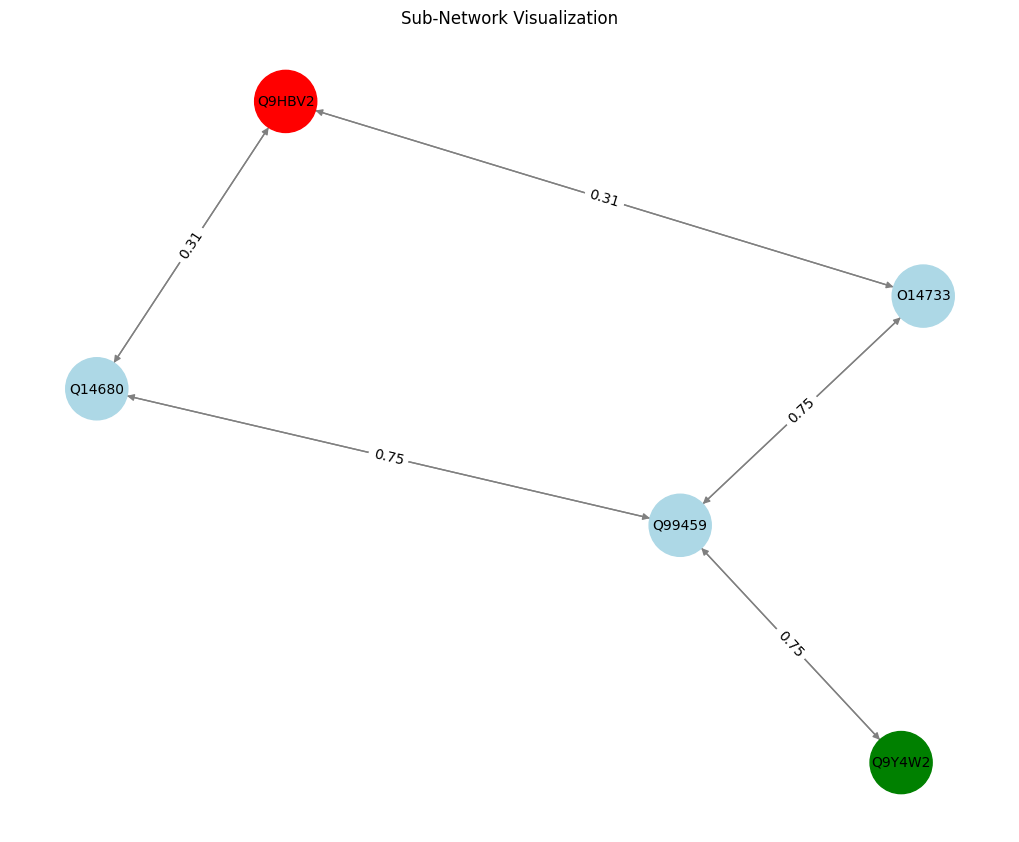

In [114]:
# Function to visualize the sub-network formed by the shortest paths
def visualize_subnetwork(graph, paths, output_image, source, target):
    """
    Extracts and visualizes the sub-network formed by the shortest paths.

    Args:
        graph (networkx.DiGraph): The PPI network.
        paths (list): List of shortest paths.
        output_image (str): File name to save the visualization.
        source (str): Source protein ID.
        target (str): Target protein ID.
    """
    subgraph_nodes = set()  # Set to collect unique nodes from paths
    for path, _, _ in paths:
        subgraph_nodes.update(path)  # Add all nodes from each path
    
    subgraph = graph.subgraph(subgraph_nodes)  # Create a subgraph with selected nodes
    
    # Define layout for visualization
    pos = nx.spring_layout(subgraph)  
    # Create edge labels with interaction weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
    
    # Color nodes differently for source and target
    node_colors = ['red' if node == source else 'green' if node == target else 'lightblue' for node in subgraph.nodes]
    
    # Create the visualization
    plt.figure(figsize=(10, 8))
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color='gray', 
            node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    
    plt.title("Sub-Network Visualization")
    plt.savefig(output_image)  # Save the plot as an image
    plt.show()

# Example usage: Visualize and save the sub-network formed by shortest paths
print("Path_1")
print(lin_shortest_paths[0])
visualize_subnetwork(ppi_network, lin_shortest_paths, "subnetwork_enhanced.png", source_protein, target_protein)

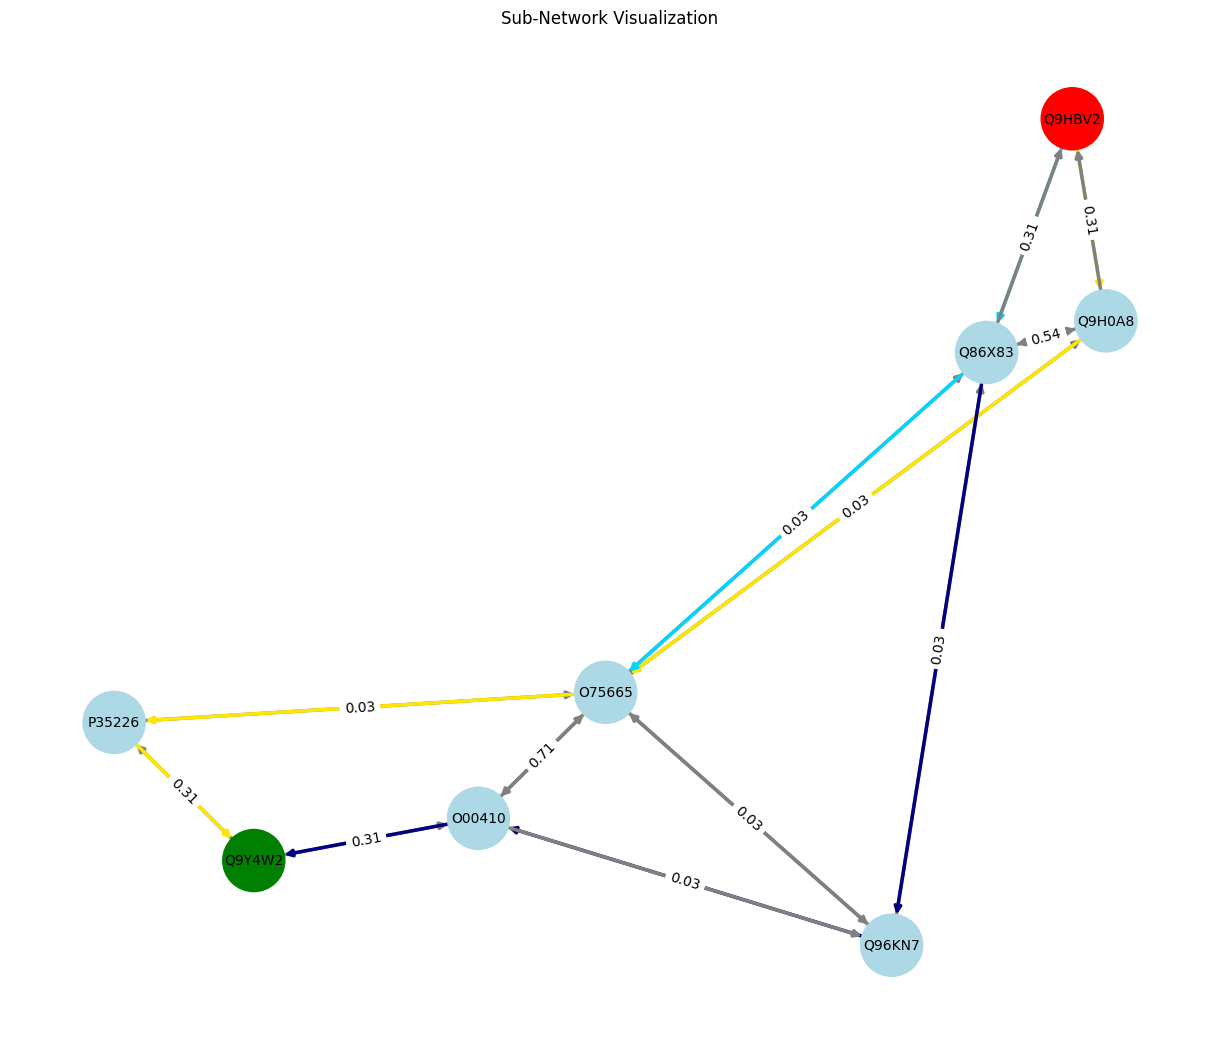

In [72]:
# Function to visualize the sub-network formed by the shortest paths
def visualize_subnetwork(graph, paths, output_image, source, target):
    """
    Extracts and visualizes the sub-network formed by the shortest paths.

    Args:
        graph (networkx.DiGraph): The PPI network.
        paths (list): List of shortest paths.
        output_image (str): File name to save the visualization.
        source (str): Source protein ID.
        target (str): Target protein ID.
    """
    subgraph_nodes = set()  # Set to collect unique nodes from paths
    edges = []
    for path, _, _ in paths:
        subgraph_nodes.update(path)  # Add all nodes from each path
        edges.extend([(path[i], path[i+1]) for i in range(len(path) - 1)])
    
    subgraph = graph.subgraph(subgraph_nodes)  # Create a subgraph with selected nodes
    
    # Define layout for visualization
    pos = nx.spring_layout(subgraph)  
    # Create edge labels with interaction weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
    
    # Color nodes differently for source and target, and annotate
    node_colors = ['red' if node == source else 'green' if node == target else 'lightblue' for node in subgraph.nodes]
    
    # Assign different colors to paths
    path_colors = [plt.cm.jet(i / len(paths)) for i in range(len(paths))]
    edge_colors = {edge: path_colors[i] for i, (path, _, _) in enumerate(paths) for edge in zip(path[:-1], path[1:])}
    edge_colors_list = [edge_colors.get(edge, 'gray') for edge in subgraph.edges()]
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, edge_color=edge_colors_list, 
        node_size=2000, font_size=10, width=2.5)    
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    #nx.draw_networkx_labels(subgraph, pos, labels={source: 'Source', target: 'Target'}, font_color='black', font_weight='bold')
    
    plt.title("Sub-Network Visualization")
    plt.savefig(output_image)  # Save the plot as an image
    plt.show()

# Example usage: Visualize and save the sub-network formed by shortest paths
visualize_subnetwork(ppi_network, shortest_paths, "subnetwork_enhanced.png", source_protein, target_protein)